<center><img src='../../img/ai4eo_logos.jpg' alt='Logos AI4EO MOOC' width='80%'></img></center>

<hr>

<br>

<a href="https://www.futurelearn.com/courses/artificial-intelligence-for-earth-monitoring/1/steps/1280514"><< Back to FutureLearn</a><br>

# Tile-based classification using Sentinel-2 L1C and EuroSAT data - Training

<i>by Nicolò Taggio, Planetek Italia S.r.l., Bari, Italy</i>

<hr>

## Watch the video tutorial

In [1]:
from IPython.display import HTML
HTML('<div align="center"><iframe src="https://player.vimeo.com/video/636104139?h=ee3c58721c" width="640" height="360" frameborder="0" allow="autoplay; fullscreen; picture-in-picture" allowfullscreen align="middle"></iframe></div>')     

<br>

<hr>

## Introduction

This workflow shows you how you can train a `Convolutional Neural Network (CNN)` with Keras based on the benchmark dataset [EuroSAT](https://arxiv.org/abs/1709.00029). The notebook provides you an introduction to the EuroSAT benchmark dataset, guides you through the preparation of training and test data and shows you how to configure and fit a Convolutional Neural Network. At the end how you can evaluate your model performance with a confusion matrix.

## Machine-Learning Algorithm

This example develops a `Sequential Convolutional Neural Network (CNN)` with Keras. CNN's are often used for image classification. `Convolutional Neural Networks` use convolutional layers (ConV layers), which are the major building blocks used in convolutional neural networks. ConV layers are in principle a set of filters, which you can think of as 2D matrices of numbers, that turn input images into the expected output.

The strength of CNN's is the abilitiy to automatically learn from a large number of filters in parallel and are often used for predicitve modelling problems, such as image classification. CNN's are often able to detect highly specific features on input images.

## Data

The model is trained on the [EuroSAT benchmark dataset](https://arxiv.org/abs/1709.00029) which is based on Sentinel-2 satellite images and consists of a total of 27,000 labeled and geo-referenced images. The dataset provides information on the following ten land cover / land use classes:
* `Annual Crop`
* `Forest`
* `Herbaceous Vegetation`
* `Highway`
* `Industrial`
* `Pasture`
* `Permanent Crop`
* `Residential`
* `River`
* `Sea Lake`

The benchmark dataset can be used to detect `land cover / land use changes`. The geo-referenced dataset EuroSAT is publicly available [here](https://github.com/phelber/eurosat).

## Further resources

* [EuroSAT: A Novel Dataset and Deep Learning Benchmark for Land Use and Land Cover Classification](https://arxiv.org/abs/1709.00029)
* [EuroSAT data](https://github.com/phelber/eurosat)

<hr>

## Notebook outline
* [1 - Load the EuroSAT benchmark dataset as input data](#load_eurosat)
* [2 - Create training and test subsets from input data](#split_test_training_eurosat)
* [3 - Define the Convolutional Neural Network architecture](#cnn_eurosat)
* [4 - Fitting (training) of the convolutional neural network](#fitting_eurosat)
* [5 - Evaluate the performance of the CNN model with a confusion matrix](#evaluate_eurosat)

<hr>

#### Import libraries

In [2]:
## BEGIN S3FS IMPORT SNIPPET ##
import os, sys
s3_home =  os.getcwd()
try: sys.path.remove(s3_home) # REMOVE THE S3 ROOT FROM THE $PATH
except Exception: pass

current_dir = os.getcwd()

os.chdir('/home/jovyan') # TEMPORARILY MOVE TO ANOTHER DIRECTORY

# BEGIN IMPORTS #
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint

import glob

import numpy as np
import pandas as pd
import seaborn as sns

from osgeo import gdal_array
from matplotlib import pyplot as plt

from sklearn import metrics
from sklearn.model_selection import train_test_split

import zipfile
# END IMPORTS #

os.chdir(current_dir) # GO BACK TO YOUR PREVIOUS DIRECTORY

sys.path.append(s3_home) # RESTORE THE S3 ROOT IN THE $PATH

## END S3FS IMPORT SNIPPET ##


#### Load helper functions

In [3]:
%run ./3B_tile-based_classification_with_EuroSAT_data_functions.ipynb

<hr>

<br>

## <a id='load_eurosat'></a>1. Load the EuroSAT benchmark dataset as input data

The `EuroSAT benchmark dataset` is in the folder `./S2_Tile_based_classification/01_Input_data/S2_tile_4_training/`. This folder contains a total of ten folders, one for each land cover class. The first step is to go through the different folders and load all the EuroSAT images as a `numpy` array. You can use the function `.LoadFile` from the [GDAL Python bindings](https://pypi.org/project/GDAL/) module `gdal_array` to read a raster image (e.g. in `.tif` format) into a `numpy.array`.

The result is `lst_arr_training`, a list of 10,000 arrays and each array has the dimension `[13, 64, 64]`. For each of the images, you want to create a `numpy.array` with ten entries indicating in binary form (0 or 1) the class the image belongs to. The resulting list is called `lst_gt_training` and has the same length as the list of training images.

**NOTE**: for training purposes, the example only makes use of a subset (10,000 images) of the EuroSAT benchmark dataset (27,000 images).

<br>

Define the folder paths where the EuroSAT training images are located.

In [4]:
 with zipfile.ZipFile("./S2_Tile_based_classification.zip", 'r') as zip_ref:
    zip_ref.extractall("/home/jovyan/")

MAIN_PATH = '/home/jovyan/S2_Tile_based_classification/'
DATA_PATH = '01_Input_data/S2_tile_4_training/'

<br>

Loop over the training data folders and build up two lists: 
* `lst_arr_training` - List of training arrays
* `lst_gt_training` - List of arrays indicating to which class each image belongs to

In [5]:
len_data_for_training_tmp = 1000

folder_for_training = glob.glob(MAIN_PATH+DATA_PATH+'*/')

print('[AI4EO_MOOC]_log: There are %d folders' % (len(folder_for_training)))

lst_arr_training=[]
lst_gt_training =[]
for i in range(0,len(folder_for_training)):
    data_for_training_tmp=glob.glob(folder_for_training[i]+'*.tif')
    
    print('[AI4EO_MOOC]_log: There are %d images for %s class' % (
        
        len_data_for_training_tmp, folder_for_training[i][40:-1])
        )
    
    for j in range(0,len_data_for_training_tmp):
        arr_tmp = gdal_array.LoadFile(data_for_training_tmp[j])
        lst_arr_training.append(arr_tmp)
        tmp_gt = np.zeros(10)
        tmp_gt[i]=1
        lst_gt_training.append(tmp_gt)

[AI4EO_MOOC]_log: There are 10 folders
[AI4EO_MOOC]_log: There are 1000 images for data/S2_tile_4_training/AnnualCrop class
[AI4EO_MOOC]_log: There are 1000 images for data/S2_tile_4_training/Forest class
[AI4EO_MOOC]_log: There are 1000 images for data/S2_tile_4_training/HerbaceousVegetation class
[AI4EO_MOOC]_log: There are 1000 images for data/S2_tile_4_training/Highway class
[AI4EO_MOOC]_log: There are 1000 images for data/S2_tile_4_training/Industrial class
[AI4EO_MOOC]_log: There are 1000 images for data/S2_tile_4_training/Pasture class
[AI4EO_MOOC]_log: There are 1000 images for data/S2_tile_4_training/PermanentCrop class
[AI4EO_MOOC]_log: There are 1000 images for data/S2_tile_4_training/Residential class
[AI4EO_MOOC]_log: There are 1000 images for data/S2_tile_4_training/River class
[AI4EO_MOOC]_log: There are 1000 images for data/S2_tile_4_training/SeaLake class


In [6]:
type(lst_gt_training[0])

numpy.ndarray

<br>

Let us inspect the length of the created lists as well as the dimensions of the images. You see that both lists have a length of 10,000 items. Each image has the dimension [13, 64, 64] and the binary class vector has a length of ten, representing the ten land cover classes.

In [7]:
print(len(lst_arr_training), len(lst_gt_training))
print(lst_arr_training[1000-1].shape, lst_gt_training[1000-1].shape)


10000 10000
(13, 64, 64) (10,)


<br>

The next step is to transform the two lists of arrays into multistack arrays. You can do this with the numpy function `.asarray()`. The result are two numpy arrays with the following specifications:
* `arr_training`: 4 dimensions (10000, 13, 64, 64) --> (number of images, bands, rows, columns)
* `arr_gt`: 2 dimensions (10000, 10) --> (number of images, columns)

In [8]:
arr_training = np.asarray(lst_arr_training)
arr_gt = np.asarray(lst_gt_training)

arr_training.shape, arr_gt.shape

((10000, 13, 64, 64), (10000, 10))

<br>

### Reshape the multi-array's native shape to an AI readable shape

Next, you have to reshape the array with the training images from its native shape (10000, 13, 64, 64) to a shape that is readable by Artificial Intelligence algorithms. For this reason, the multi-dimension array `arr_training` needs to be re-organised into the following dimensions:
* `arr_training_res`: 4 dimensions (10000, 64, 64, 13) --> (number of images, rows, columns, bands)

In [9]:
num_of_img,bands,rows,columns=arr_training.shape

print('[AI4EO_MOOC]_log: Reshape array from native shape (num_of_img:%d, bands:%d, rows:%d, columns:%d) to AI readble shape (num_of_img:%d, rows:%d, columns:%d, bands:%d). . .' % (num_of_img,bands,rows,columns, num_of_img,rows,columns,bands))

arr_training_res = np.reshape(arr_training,(num_of_img,rows,columns,bands))
arr_training_res.shape

[AI4EO_MOOC]_log: Reshape array from native shape (num_of_img:10000, bands:13, rows:64, columns:64) to AI readble shape (num_of_img:10000, rows:64, columns:64, bands:13). . .


(10000, 64, 64, 13)

In [10]:
type(arr_training_res)

numpy.ndarray

<br>

### Normalisation of the image radiances to a [0, 1] interval

As a final step, we normalize the data and bring the data into a [0, 1] range. First, you want to transform the data type from `uint16 - [0,65535]` to `float32`. Then, you loop over each image in the numpy multi-dimension array, you retrieve the maximum value of each image with the numpy function `.amax()` and then you divide each value in the array by the maximum value.

In [11]:
print('[AI4EO_MOOC]_log: Normalization data into [0,1] intervall...')
arr_training_res = arr_training_res.astype('float32')
for i in range(0, len(arr_training_res)):    
    amax_tmp=np.amax(arr_training_res[i,:,:,:])
    arr_training_res[i,:,:,:] = arr_training_res[i,:,:,:] / amax_tmp

[AI4EO_MOOC]_log: Normalization data into [0,1] intervall...


<br>

Let us inspect one image of the array. You see that the interval range is now a float number between 0 and 1.

In [12]:
arr_training_res[1000-1,:,:,:]

array([[[0.39282888, 0.39282888, 0.39335617, ..., 0.39625627,
         0.3970472 , 0.39783812],
        [0.39915633, 0.40047455, 0.40179276, ..., 0.40759292,
         0.40601107, 0.40390193],
        [0.40100184, 0.39783812, 0.39414713, ..., 0.36699182,
         0.36540997, 0.36461905],
        ...,
        [0.38333774, 0.380174  , 0.3770103 , ..., 0.37121013,
         0.37279198, 0.37437385],
        [0.37621936, 0.37806487, 0.37964672, ..., 0.38149223,
         0.3807013 , 0.37964672],
        [0.37859213, 0.3778012 , 0.3770103 , ..., 0.37463748,
         0.37463748, 0.37490115]],

       [[0.3862378 , 0.3862378 , 0.3872924 , ..., 0.39783812,
         0.3988927 , 0.39968362],
        [0.40047455, 0.4007382 , 0.40100184, ..., 0.38755602,
         0.3843923 , 0.38149223],
        [0.37859213, 0.3759557 , 0.37358293, ..., 0.37463748,
         0.37621936, 0.3778012 ],
        ...,
        [0.3807013 , 0.38201952, 0.38307407, ..., 0.39177433,
         0.39177433, 0.39151067],
        [0.3

<br>

## <a id='split_test_training_eurosat'></a>2. Create training and test subsets from input data

Let us now randomly split the training data into a `training subset` and a `testing subset`. Scikit-learn offers a popular function called `train_test_split()`, which creates four subsets based on the input and output variables `X - arr_training_res` and `y - arr_gt`. The function takes the following kwargs:

* `arrays`: input and output data arrays
* `test_size`: a float number representing the proportion of the input dataset to include in the test subset
* `random_state`: An integer assuring reproducibility of the random shuffling of the data 

Let us use 85% of the input data for training and 15% for testing.

In [13]:
test_size=0.15
print('[AI4EO_MOOC]_log: Training (%0.2f %%) and validation (%0.2f %%) split..' % (
    (1-test_size)*100,(test_size)*100))

X_train, X_test, y_train, y_test = train_test_split(
        arr_training_res,
        arr_gt, 
        test_size=test_size, 
        random_state=42)

[AI4EO_MOOC]_log: Training (85.00 %) and validation (15.00 %) split..


<br>

## <a id='cnn_eurosat'></a>3. Define the Convolutional Neural Network architecture

First, we initiate a `sequential neural network` model with the Keras class `keras.Sequential()`.

In [14]:
_, num_classes = y_train.shape
print('[AI4EO_MOOC]_log: Convolutional Neural Network architecture:')
model = keras.Sequential()

[AI4EO_MOOC]_log: Convolutional Neural Network architecture:


<br>

The next step is to build up the architecture of the `Convolutional Neural Network (CNN)`, with the function `model.add()`. 
A `CNN` composes of the following set of layers:
* `Conv2D`: Convolutional layer with number of filters, e.g. 32 or 64, the shape of the filter ((3,3), (5,5), ...) and the application of padding
* `Activation`: Activation layer, e.g. `relu`, `sigmod`, ...
* `MaxPooling2D`: Max Pooling layer with shape (2,2), (3,3), ...
* `Dropout`: to reduce overfitting

In the following code block, we build three blocks of layers: 

* **First block of layers**<br>
The first block of layers conists of two `Conv2D` layers with 32 neurons and we add non-linear properties by adding an `Activation` layer in between. We then define a `MaxPooling2D`layer, which downsamples the input by taking the maximum value of a given window size. The block of layers finishes with a `Dropout` layer, which randomly skips 25% of the interconnections.

* **Second block of layers**<br>
The second block of layers conists again of two `Conv2D` layers, but this time with 64 neurons and we add non-linear properties by adding an `Activation` layer in between. We then define a `MaxPooling2D`layer, which downsamples the input by taking the maximum value of a given window size. The block of layers finishes with a `Dropout` layer, which randomly skips 25% of the interconnections.

* **Third block of layers**<br>
The third block consists of two `Dense` layers, which are fully-connected layers. In between, we again add non-linear properties by adding an `Activation` layer. The number of neurons of the final `Dense` layer has to be the same as the number of land use classes.

In [15]:
model.add(Conv2D(32, (3, 3), padding='same', input_shape=X_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))


<br>

After the model architecture has been defined, you can compile (configure) the model with `model.compile()` and define the following hyperparameters:
* `loss='categorical_crossentropy'` - Categorical crossentropy is one of many loss options and calculates the crossentropy loss between the labels and the predictions
* `optimizer=RMSprop(lr=0.0001, decay=1e-6)` - Optimizers are algorithms the network learns from
* `metrics=['accuracy']` - is used to evaluate how the model is performing

In [16]:
opt = keras.optimizers.RMSprop(lr=0.0001, decay=1e-6)

model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

<br>

The function `model.summary()` provides you a tabular summary of the `CNN architecture`, which is helpful to see the output shape of the model after each operation.

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 32)        3776      
_________________________________________________________________
activation (Activation)      (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 62, 62, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 62, 62, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 31, 31, 64)        1

<br>

## <a id='fitting_eurosat'></a>4. Fitting (training) of the convolutional neural network

The next step in the training process is the actual training (fitting) of the model. Since the training process is time-consuming (depening on the technical capabilities of your machine as well as the architecture of your model), it is a common practise to save the model with the best accuracy. The saved model can then be re-loaded without the need to repeat the training process.

Let us set the folder path to which the model with the best validation accuracy is saved to. The pre-trained model is saved in the folder `02_pretrained_model`.

In [18]:
save_dir = MAIN_PATH + '02_pretrained_model/'
model_name = 'keras_sentinel2_classification_trained_model_e50.json'

filepath_tmp = save_dir+model_name
filepath_tmp

'./S2_Tile_based_classification/02_pretrained_model/keras_sentinel2_classification_trained_model_e50.json'

<br>

`Callbacks` are utilities that are called at certain points during model training. They can support you in better understanding the performance of your model during training. One useful callback is [ModelCheckpoint](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint), which allows you to save the Keras model after training. With the class `ModelCheckpoint` you can define the type of information you would like to save.

The following code saves only the model with the best `validation accuracy`.

In [19]:
checkpoint = ModelCheckpoint(
    filepath_tmp, 
    'val_accuracy', 
    verbose=1, 
    save_best_only=True, 
    mode='max')
callbacks_list = [checkpoint]

<br>

The final step is to train (fit) the Keras model. You can use `model.fit()` to fit the model based on the training dataset. The resulting object is a `history` object and a common practise is to call the output of the training process `history`.

The function `model.fit()` requires you to specify the following parameters:
* `input (X)` and `output (y)` data: here we specify the input and output training data of your model
* `validation_data`: here we enter the test data subsets X_test and y_test and our model outputs are validated against these validation data after each epoch (training cycle)
* `epochs`: number of training cycles
* `batch_size`: defines the size of a training data subset (e.g. 32 samples) after which the weights of the network are updated
* `callbacks`: define here the callbacks you would like to make use of during the training process
* `verbose`: specify how the progress of the training shall be shown - option 0, 1, 2 - option 1 for example shows you a progress bar for each epoch

In [20]:
batch_size = 32
epochs = 10

history = model.fit(X_train, y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(X_test, y_test),
                    callbacks=callbacks_list,
                    verbose = 1)   
   

Epoch 1/10
266/266 [==============================] - 71s 263ms/step - loss: 1.6832 - accuracy: 0.3857 - val_loss: 1.0249 - val_accuracy: 0.6440

Epoch 00001: val_accuracy improved from -inf to 0.64400, saving model to ./S2_Tile_based_classification/02_pretrained_model/keras_sentinel2_classification_trained_model_e50.json
INFO:tensorflow:Assets written to: ./S2_Tile_based_classification/02_pretrained_model/keras_sentinel2_classification_trained_model_e50.json/assets
Epoch 2/10
266/266 [==============================] - 68s 257ms/step - loss: 1.0403 - accuracy: 0.6201 - val_loss: 0.8610 - val_accuracy: 0.6660

Epoch 00002: val_accuracy improved from 0.64400 to 0.66600, saving model to ./S2_Tile_based_classification/02_pretrained_model/keras_sentinel2_classification_trained_model_e50.json
INFO:tensorflow:Assets written to: ./S2_Tile_based_classification/02_pretrained_model/keras_sentinel2_classification_trained_model_e50.json/assets
Epoch 3/10
266/266 [==============================] - 7

<br>

## <a id='evaluate_eurosat'></a>5. Evaluate the performance of the CNN model with a confusion matrix

The final step is to evaluate the performance of your model and the model's ability to classify land cover / land use with the help of the test data. With the function `model.predict()`, you can classify the test input data (`X_test`). The result `y_pred` is an array with the dimensions `(1500, 10)`. For each input image of the test data, the prediction provides a vector which holds for each class the probability of the class.

In [21]:
y_pred = model.predict(X_test)
y_pred.shape

(1500, 10)

<br>

The final classification result is the class with the highest probability. The aim is to have a vector with the same length of the number of test images, which provides for each image the final predicted class. For this, we have to loop over the predicted (`y_pred`) and test (`y_test`) output arrays and retrieve the index of the argument with the maximum value. You can retrieve the index of the argument with the maximum value with numpy's function `np.argmax()`.

The result are two one dimensional arrays, `y_pred_amax` and `y_test_amax`, providing the index of the land cover class for each image.

In [22]:
y_pred_amax=np.zeros((len(y_pred)))    
y_test_amax=np.zeros((len(y_pred)))

for i in range(0,len(y_pred)):
    y_pred_amax[i]=np.argmax(y_pred[i,:])
    y_test_amax[i]=np.argmax(y_test[i,:])
    
y_test_amax, y_pred_amax

(array([6., 4., 1., ..., 6., 6., 3.]), array([6., 4., 1., ..., 6., 6., 3.]))

<br>

### Create a confusion matrix

Classification accuracy alone can often be misleading, especially if you have an unequal number of observations in each class or if you have more than two classes in your dataset. A confusion matrix can give you a better idea of what your model is getting right and what type of errors it is making. A `confusion matrix` is also known as error matrix and is a common technique for summarizing the performance of a classification algorithm. 

The metrics class of the scikit-learn package offers the function `confusion_matrix`, which computes the confusion matrix between the actual (`y_test_amax`) and predicted class (`y_pred_amax`). The result is a matrix which summarizes the number of correct and incorrect predictions with count values broken down by each class. The rows indicate the actual class and the columns indicate the predicted class.

In [23]:
matrix = metrics.confusion_matrix(y_test_amax, y_pred_amax) 
matrix

array([[ 86,   2,  20,   9,   0,   3,  40,   1,   0,   0],
       [  0, 147,   2,   0,   0,   1,   1,   0,   0,   0],
       [  0,   2, 133,   0,   0,   3,   1,   0,   0,   1],
       [  3,   3,  22,  77,   3,  17,   8,  15,   1,   0],
       [  0,   0,   2,   1, 141,   0,   0,  10,   2,   0],
       [  0,  12,   9,   0,   0, 113,   5,   0,   0,   0],
       [  2,   0,  16,   5,   0,   2, 125,   3,   0,   0],
       [  0,   1,   2,   2,   2,   0,   2, 146,   0,   0],
       [  0,   2,   4,   7,   1,   4,   0,   0, 148,   1],
       [  0,   0,   0,   0,   0,   0,   0,   0,   1, 128]])

<br>

Let us convert the matrix into a `pandas.dataframe` and add class labels to the rows and columns. This helps to better interpret the results.

In [24]:
label_str=[
    'AnnualCrop',
    'Forest',
    'HerbaceousVegetation',
    'Highway',
    'Industrial',
    'Pasture',
    'PermanentCrop',
    'Residential',
    'River',
    'SeaLake' ]


con_mat_df = pd.DataFrame(matrix,
                                index  = label_str,
                                columns= label_str)
con_mat_df

,AnnualCrop,Forest,HerbaceousVegetation,Highway,Industrial,Pasture,PermanentCrop,Residential,River,SeaLake
AnnualCrop,86,2,20,9,0,3,40,1,0,0
Forest,0,147,2,0,0,1,1,0,0,0
HerbaceousVegetation,0,2,133,0,0,3,1,0,0,1
Highway,3,3,22,77,3,17,8,15,1,0
Industrial,0,0,2,1,141,0,0,10,2,0
Pasture,0,12,9,0,0,113,5,0,0,0
PermanentCrop,2,0,16,5,0,2,125,3,0,0
Residential,0,1,2,2,2,0,2,146,0,0
River,0,2,4,7,1,4,0,0,148,1
SeaLake,0,0,0,0,0,0,0,0,1,128


<br>

Now, you can use the `heatmap()` function of the seaborn library to visualize the confusion matrix, which gives you a more visual picture of the classification performance of the model.

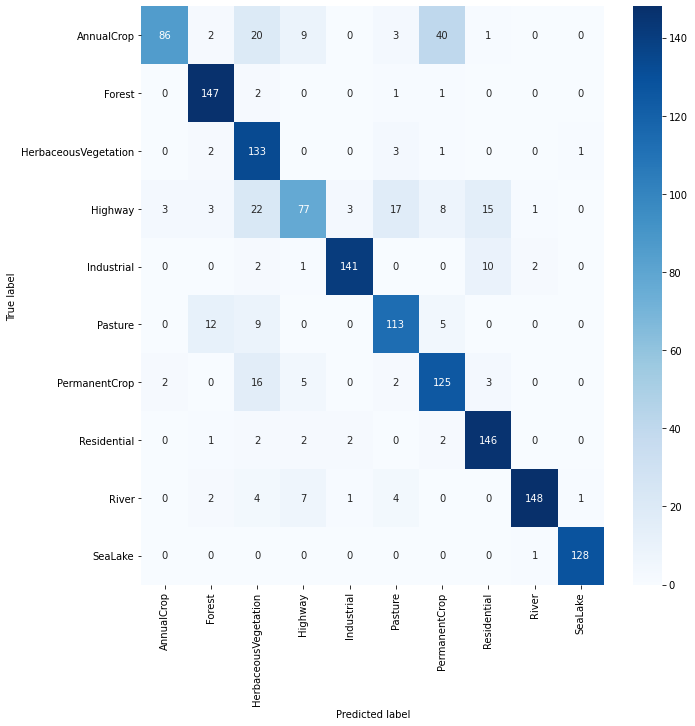

In [25]:
plt.figure(figsize=(10, 10))
sns.heatmap(con_mat_df,
            annot=True,
            fmt='d',
            cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

<br>

Alternatively, you can also normalize the confusion matrix, which makes it often easier to interpret how the classes are predicted by the model. You can create the `normalized confusion matrix` also with the function `confusion_matrix` from scikit-learn's 'metrics' class, but you have to set the keyword argument `normalize` to true.

In [26]:
matrix_norm = metrics.confusion_matrix(y_test_amax, y_pred_amax, normalize='true') 

matrix_norm = np.around(matrix_norm,decimals=2)

<br>

Now, you can also transform the normalized matrix to a pandas data frame. You see now that the matrix represents relative frequencies per row.

In [27]:
con_mat_df_norm = pd.DataFrame(matrix_norm,
                          index  = label_str,
                          columns= label_str)
con_mat_df_norm

,AnnualCrop,Forest,HerbaceousVegetation,Highway,Industrial,Pasture,PermanentCrop,Residential,River,SeaLake
AnnualCrop,0.53,0.01,0.12,0.06,0.00,0.02,0.25,0.01,0.00,0.00
Forest,0.00,0.97,0.01,0.00,0.00,0.01,0.01,0.00,0.00,0.00
HerbaceousVegetation,0.00,0.01,0.95,0.00,0.00,0.02,0.01,0.00,0.00,0.01
Highway,0.02,0.02,0.15,0.52,0.02,0.11,0.05,0.10,0.01,0.00
Industrial,0.00,0.00,0.01,0.01,0.90,0.00,0.00,0.06,0.01,0.00
Pasture,0.00,0.09,0.06,0.00,0.00,0.81,0.04,0.00,0.00,0.00
PermanentCrop,0.01,0.00,0.10,0.03,0.00,0.01,0.82,0.02,0.00,0.00
Residential,0.00,0.01,0.01,0.01,0.01,0.00,0.01,0.94,0.00,0.00
River,0.00,0.01,0.02,0.04,0.01,0.02,0.00,0.00,0.89,0.01
SeaLake,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.99


<br>

As a final step, you can visualize the `normalized confusion matrix` with the function `heatmap()` from the seaborn library.

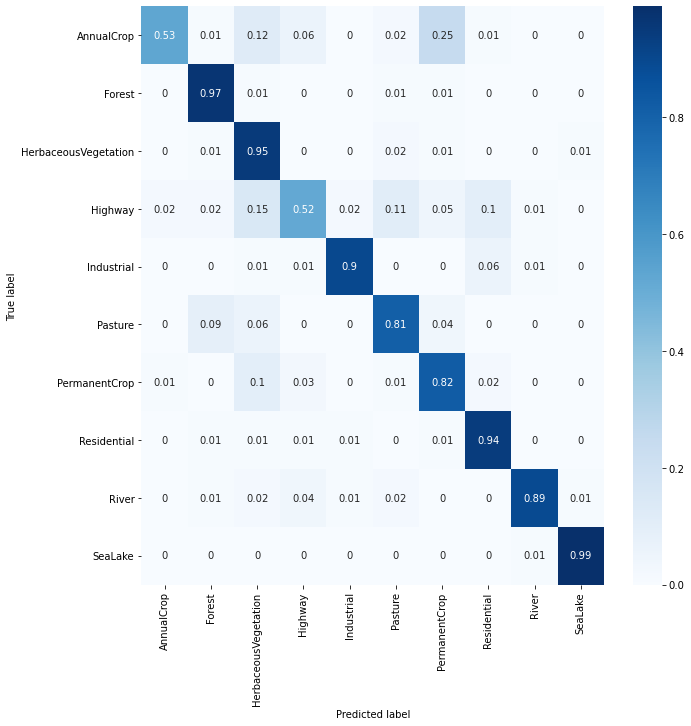

In [28]:

    
plt.figure(figsize=(10, 10))
sns.heatmap(con_mat_df_norm,
            annot=True,
            cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

<br>

<br>

<a href="https://www.futurelearn.com/courses/artificial-intelligence-for-earth-monitoring/1/steps/1170903"><< Back to FutureLearn</a><br>

<hr>

<img src='../../img/copernicus_logo.png' alt='Copernicus logo' align='left' width='20%'></img>

Course developed for [EUMETSAT](https://www.eumetsat.int/), [ECMWF](https://www.ecmwf.int/) and [Mercator Ocean International](https://www.mercator-ocean.fr/en/) in support of the [EU’s Copernicus Programme](https://www.copernicus.eu/en) and the [WEkEO platform](https://wekeo.eu/).
